In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

In [2]:
from src.signature_detect.loader import Loader
from src.signature_detect.judger import Judger
from src.signature_detect.cropper import Cropper
from src.signature_detect.extractor import Extractor

In [45]:
def show_image(
    img, cmap="gray", dpi=200, split_labels=False, labels=None, assume_bgr=False
):
    """
    Display:
      - an image (PIL/NumPy/path),
      - a list/tuple of images/paths,
      - a NumPy stack (N,H,W[,C]) -> each frame in its own figure,
      - a 2D mask (HxW) -> shown with discrete colormap; if split_labels=True, one figure per label,
      - a mask stack (K,H,W) or (H,W,K) -> each mask slice as its own figure,
      - *all pages* of a PDF path (each page in its own figure).

    Parameters
    ----------
    img : path | PIL.Image | np.ndarray | list/tuple
    cmap : str
        Colormap for single-channel images (not used for masks with many labels).
    dpi : int
        Render DPI for PDFs.
    split_labels : bool
        If True and a 2D integer label mask is provided (multiple unique values),
        split into binary masks and show each one separately.
    labels : list[int] | None
        When split_labels=True, optionally restrict to these label values.
        (0 is typically background and is skipped by default.)
    assume_bgr : bool
        If True and a 3-channel image is provided (HxWx3), convert BGR->RGB to avoid blueish tint.
        Useful if the data came from OpenCV (cv2) which loads as BGR.
    """
    # If a list/tuple, display each item
    if isinstance(img, (list, tuple)):
        for item in img:
            show_image(
                item,
                cmap=cmap,
                dpi=dpi,
                split_labels=split_labels,
                labels=labels,
                assume_bgr=assume_bgr,
            )
        return

    # Path input?
    if isinstance(img, (str, Path)):
        p = Path(img)
        if not p.exists():
            raise FileNotFoundError(f"No such file: {p}")

        if p.suffix.lower() == ".pdf":
            import fitz  # PyMuPDF

            doc = fitz.open(str(p))
            try:
                zoom = dpi / 72.0
                mat = fitz.Matrix(zoom, zoom)
                for i in range(doc.page_count):
                    page = doc.load_page(i)
                    pix = page.get_pixmap(matrix=mat, alpha=False)
                    pil_img = Image.frombytes(
                        "RGB", (pix.width, pix.height), pix.samples
                    )
                    _imshow_array(np.array(pil_img), cmap=cmap, assume_bgr=assume_bgr)
            finally:
                doc.close()
            return
        else:
            pil_img = Image.open(p)
            _imshow_array(np.array(pil_img), cmap=cmap, assume_bgr=assume_bgr)
            return

    # PIL Image
    if isinstance(img, Image.Image):
        _imshow_array(np.array(img), cmap=cmap, assume_bgr=assume_bgr)
        return

    # NumPy array handling
    if isinstance(img, np.ndarray):
        arr = img

        # 2D -> mask or grayscale image
        if arr.ndim == 2:
            _imshow_2d(arr, cmap=cmap, split_labels=split_labels, labels=labels)
            return

        # 3D
        if arr.ndim == 3:
            H, W, D = arr.shape

            # Case A: channels-last RGB/RGBA or single-channel (HxWx{1,3,4})
            if D in (1, 3, 4):
                _imshow_array(arr, cmap=cmap, assume_bgr=assume_bgr)
                return

            # Case B: it's a stack either (K,H,W) or (H,W,K)
            # Prefer axis 0 or axis 2 when size is "small" (<=64) for #masks
            if arr.shape[0] <= 64:
                axis = 0  # (K,H,W)
            elif arr.shape[2] <= 64:
                axis = 2  # (H,W,K)
            else:
                # Fallback: treat as (H,W,D) multi-slice -> show each slice
                axis = 2

            num = arr.shape[axis]
            for k in range(num):
                slice_k = np.take(arr, k, axis=axis)
                # ensure 2D for display as mask/gray
                if slice_k.ndim == 2:
                    _imshow_2d(slice_k, cmap=cmap, split_labels=False)
                elif slice_k.ndim == 3 and slice_k.shape[-1] in (1, 3, 4):
                    _imshow_array(slice_k, cmap=cmap, assume_bgr=assume_bgr)
                else:
                    # try squeezing singleton channel
                    _imshow_2d(np.squeeze(slice_k), cmap=cmap, split_labels=False)
            return

        # 4D -> stack of frames (N,H,W[,C]) or (N,K,H,W)
        if arr.ndim == 4:
            N = arr.shape[0]
            for n in range(N):
                frame = arr[n]
                if frame.ndim == 2:
                    _imshow_2d(
                        frame, cmap=cmap, split_labels=split_labels, labels=labels
                    )
                elif frame.ndim == 3 and frame.shape[-1] in (1, 3, 4):
                    _imshow_array(frame, cmap=cmap, assume_bgr=assume_bgr)
                elif frame.ndim == 3:
                    # (K,H,W) within each frame
                    K = frame.shape[0]
                    for k in range(K):
                        _imshow_2d(frame[k], cmap=cmap, split_labels=False)
                else:
                    raise ValueError(f"Unsupported frame shape: {frame.shape}")
            return

        raise ValueError(f"Unsupported ndarray shape: {arr.shape}")

    raise TypeError(
        "img must be a path, PIL.Image.Image, np.ndarray, or a list/tuple of these."
    )


# ---------------- helpers ----------------


def _imshow_array(arr, cmap="gray", assume_bgr=False):
    """Show a regular image array (handles grayscale or color), with optional BGR->RGB fix."""
    fig, ax = plt.subplots(figsize=(10, 6))

    if arr.ndim == 2:
        ax.imshow(arr, cmap=cmap)
    else:
        # Handle BGR->RGB if requested and looks like HxWx3
        if assume_bgr and arr.ndim == 3 and arr.shape[-1] == 3:
            arr = arr[..., ::-1]
        ax.imshow(arr)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


def _imshow_2d(arr2d, cmap="gray", split_labels=False, labels=None):
    """
    Show 2D data:
    - If split_labels=True and array looks like a label image (ints with many uniques),
      split into per-label binary masks and show each separately.
    - Else: if mask-like (few uniques or int/bool), use a discrete colormap.
            otherwise show as grayscale.
    """
    is_int_like = np.issubdtype(arr2d.dtype, np.integer) or arr2d.dtype == np.bool_
    uniq = np.unique(arr2d)

    # Split per label if requested and it's a label map (more than 2 unique ints)
    if split_labels and is_int_like and len(uniq) > 2:
        # Choose labels to show
        if labels is None:
            labels_to_show = [u for u in uniq if u != 0]  # skip background=0 by default
        else:
            labels_set = set(labels)
            labels_to_show = [u for u in uniq if u in labels_set]

        for lab in labels_to_show:
            fig, ax = plt.subplots(figsize=(10, 6))
            binary = arr2d == lab
            ax.imshow(binary, cmap="gray")  # binary mask
            ax.set_title(f"Label {lab}")
            ax.set_axis_off()
            plt.tight_layout()
            plt.show()
        return

    # Otherwise: single figure. If mask-like, use discrete colors.
    unique_count = len(uniq)
    is_maskish = is_int_like or (unique_count <= 64)

    fig, ax = plt.subplots(figsize=(10, 6))
    if is_maskish:
        ax.imshow(arr2d, cmap="tab20", interpolation="nearest")
    else:
        ax.imshow(arr2d, cmap=cmap)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Image

In [46]:
doc_path = r"data_pdf\R698\AE1.pdf"

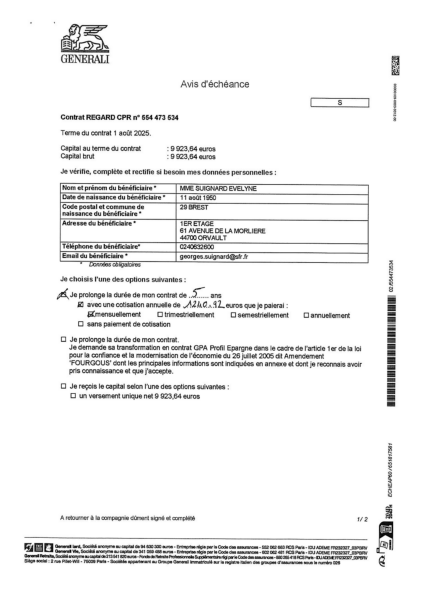

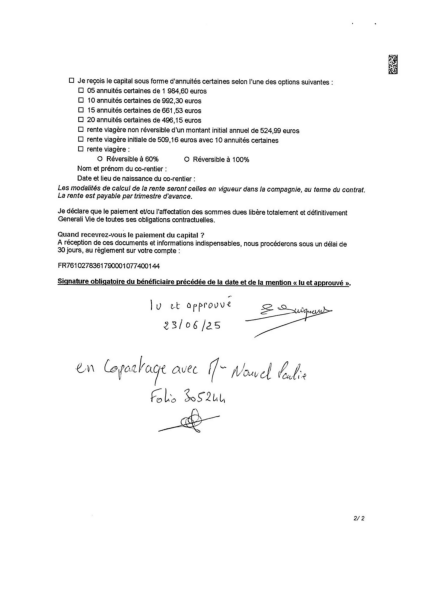

In [47]:
show_image(doc_path)

## Loader

The loader reads the file and creates a mask. 

The mask is a numpy array. The bright parts are set to 255, the rest is set to 0.

In [48]:
loader = Loader((0, 0, 0), (255, 255, 80))
print(loader)


Loader
low_threshold = (0, 0, 0)
high_threshold = (255, 255, 80)



In [49]:
mask = loader.get_masks(doc_path)
print(mask)
print(np.unique(mask))

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(2339, 1653), dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(2339, 1653), dtype=uint8)]
[  0 255]


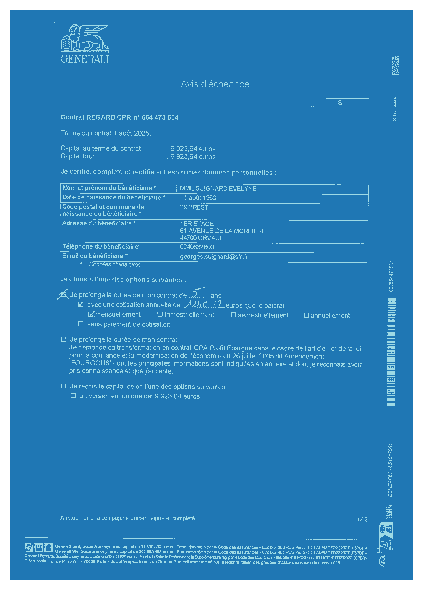

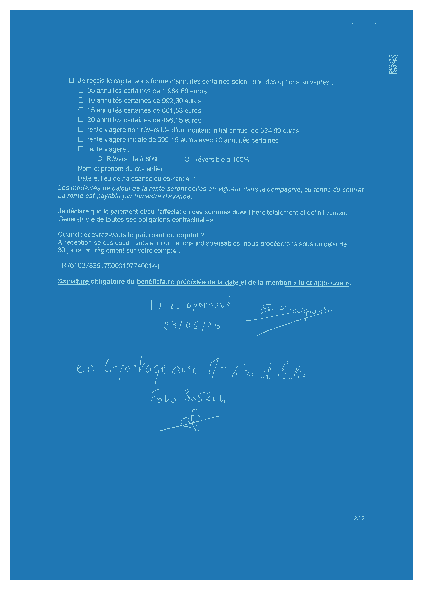

In [50]:
show_image(mask)
# plt.imsave('./data/output/mask.jpeg', mask)

## Extractor

The extractor 

1. generates the regions from the mask.
2. removes the small and the big region because the signature is neither too big nor too small.

In [51]:
extractor = Extractor(outlier_weight=3, outlier_bias=20, amplfier=15, min_area_size=10)

print(extractor)


Extractor
outlier_weight = 3
outlier_bias = 20
> small_outlier_size = outlier_weight * average_region_size + outlier_bias
amplfier = 15
> large_outlier_size = amplfier * small_outlier_size
min_area_size = 10 (pixels)
> min_area_size is used to calculate average_region_size.



[Extractor] Total components before filtering: 1668
[Extractor] avg_area=118.1, small_thr=374.25737265415546, big_thr=5613.860589812331
[Extractor] Pixels kept after filtering: 12903
[  0 255]


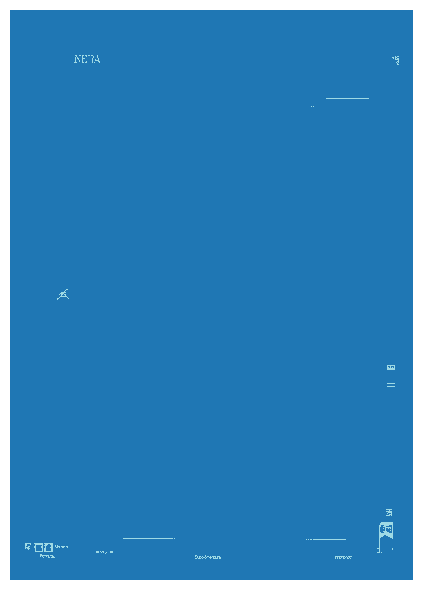

[Extractor] Total components before filtering: 1213
[Extractor] avg_area=89.4 too small → using fallback thresholds
[Extractor] avg_area=89.4, small_thr=100, big_thr=50000
[Extractor] Pixels kept after filtering: 42233
[  0 255]


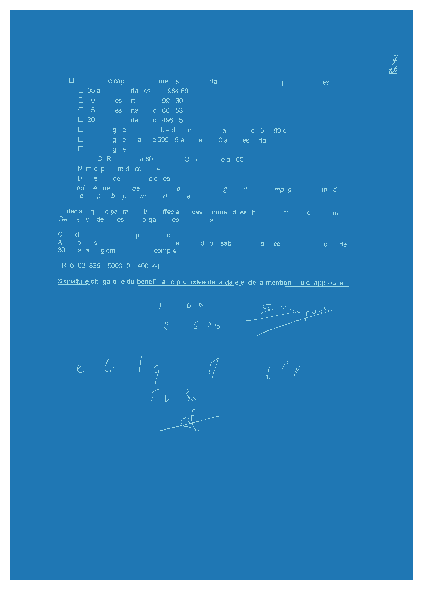

In [52]:
for m in mask:
    labeled = extractor.extract(m)
    print(np.unique(labeled))
    show_image(labeled)

    # plt.imsave('./data/output/labeled_mask.jpeg', labeled_mask)

## Cropper

The cropper finds the **contours** of regions in the **labeled masks** and crop them.

In [53]:
cropper = Cropper(min_region_size=5000)
print(cropper)


Cropper
min_region_size = 5000
border_ratio = 0.02



[Extractor] Total components before filtering: 1668
[Extractor] avg_area=118.1, small_thr=374.25737265415546, big_thr=5613.860589812331
[Extractor] Pixels kept after filtering: 12903
[  0 255]


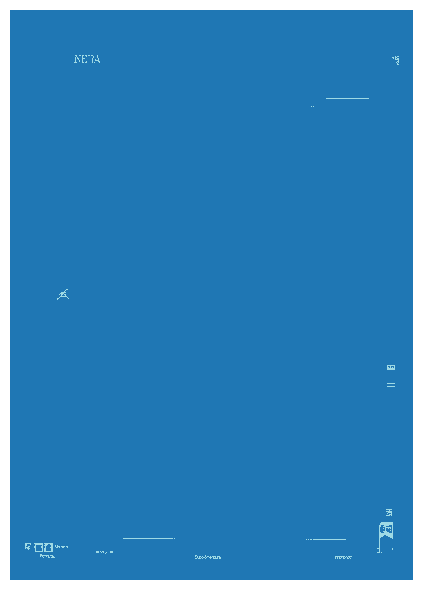

{0: {'cropped_region': [1233, 360, 241, 39], 'cropped_mask': array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0, 255,   0],
       ...,
       [  0,   0, 255, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255, 255,   0]], shape=(39, 241), dtype=uint8)}, 1: {'cropped_region': [1505, 2100, 65, 128], 'cropped_mask': array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], shape=(128, 65), dtype=uint8)}, 2: {'cropped_region': [310, 2166, 1070, 8], 'cropped_mask': array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,

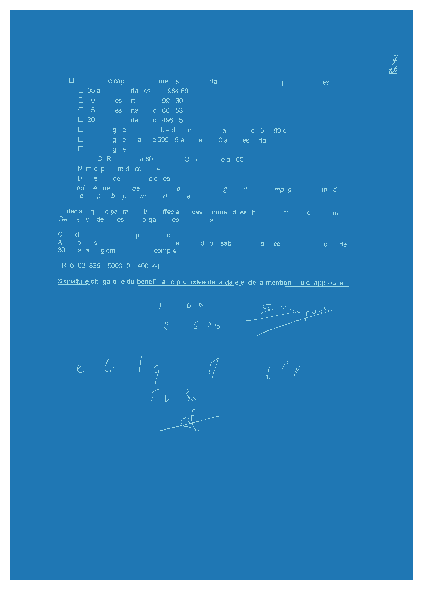

{0: {'cropped_region': [968, 1220, 352, 122], 'cropped_mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(122, 352), dtype=uint8)}, 1: {'cropped_region': [196, 1107, 1195, 29], 'cropped_mask': array([[  0, 255, 255, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], shape=(29, 1195), dtype=uint8)}, 2: {'cropped_region': [610, 1638, 249, 94], 'cropped_mask': array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,

In [54]:
for m in mask:
    labeled = extractor.extract(m)
    print(np.unique(labeled))
    show_image(labeled)

    # plt.imsave('./data/output/labeled_mask.jpeg', labeled_mask)

    results = cropper.run(labeled)
    print(results)

## Judger

The judger reads the cropped mask and identifies if it's a signature or not.

In [55]:
judger = Judger()
print(judger)


Judger
size_ratio = [1, 10]
pixel_ratio = [0.1, 50]



[Extractor] Total components before filtering: 1668
[Extractor] avg_area=118.1, small_thr=374.25737265415546, big_thr=5613.860589812331
[Extractor] Pixels kept after filtering: 12903


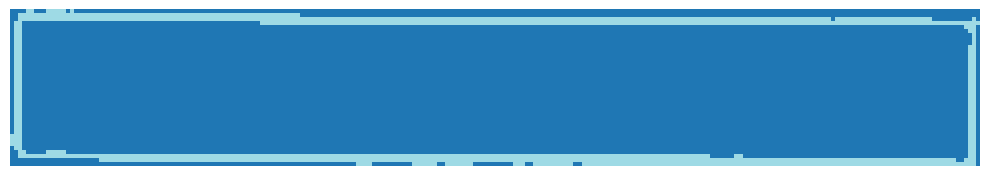

Region 0: Signed


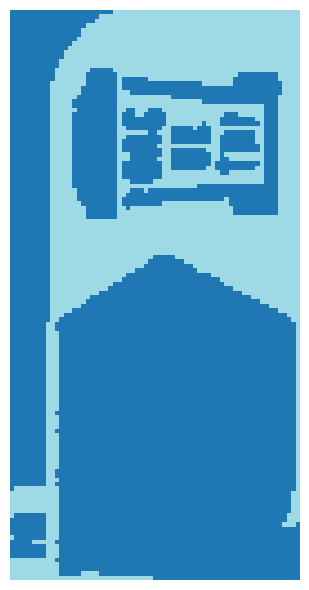

Region 1: Signed


Region 2: Not Signed
[Extractor] Total components before filtering: 1213
[Extractor] avg_area=89.4 too small → using fallback thresholds
[Extractor] avg_area=89.4, small_thr=100, big_thr=50000
[Extractor] Pixels kept after filtering: 42233


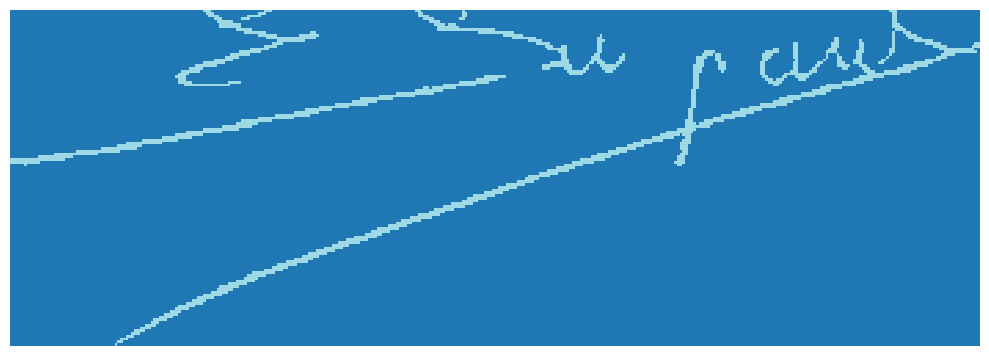

Region 0: Signed


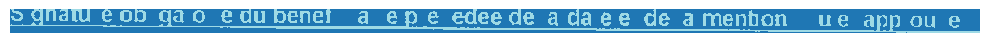

Region 1: Not Signed


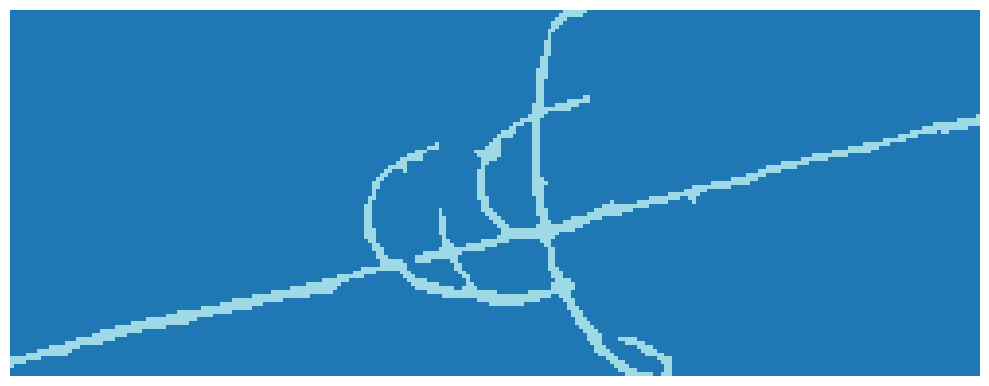

Region 2: Signed
[{'id': 0, 'signed': True, 'box': [1233, 360, 241, 39]}, {'id': 1, 'signed': True, 'box': [1505, 2100, 65, 128]}, {'id': 2, 'signed': False, 'box': [310, 2166, 1070, 8]}, {'id': 0, 'signed': True, 'box': [968, 1220, 352, 122]}, {'id': 1, 'signed': False, 'box': [196, 1107, 1195, 29]}, {'id': 2, 'signed': True, 'box': [610, 1638, 249, 94]}]


In [56]:
regions = []

for m in mask:
    labeled = extractor.extract(m)
    results = cropper.run(labeled)

    for idx, result in results.items():
        signature = result["cropped_mask"]
        show_image(signature)
        result = judger.judge(signature)
        info = f"Region {idx}: {'Signed' if result else 'Not Signed'}"
        print(info)
        regions.append(
            {"id": idx, "signed": result, "box": results[idx]["cropped_region"]}
        )

print(regions)

## Not signed doc test

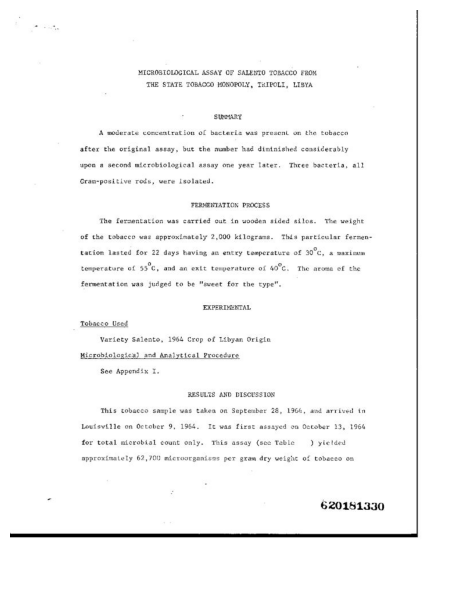

In [38]:
not_signed_doc_path = r"Datasets/unsigned/scientific_report/0001076990.jpg"

show_image(not_signed_doc_path)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[  0 255]


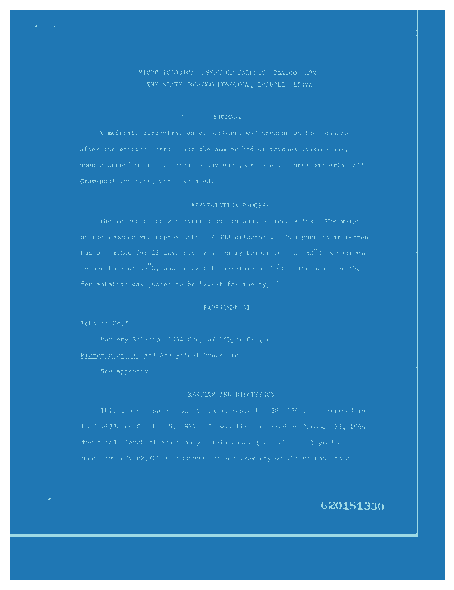

In [39]:
mask = loader.get_masks(not_signed_doc_path)[0]
print(mask)
print(np.unique(mask))
show_image(mask)

[Extractor] Total components before filtering: 2577
[Extractor] avg_area=121.6, small_thr=384.7755102040816, big_thr=5771.632653061224
[Extractor] Pixels kept after filtering: 4973
[  0 255]


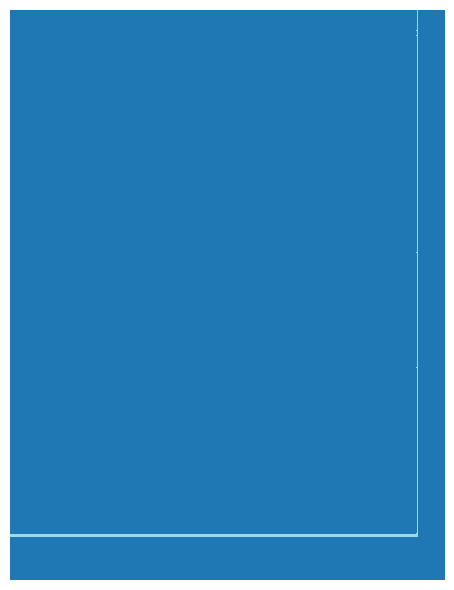

In [40]:
labeled_mask = extractor.extract(mask)
print(np.unique(labeled_mask))
show_image(labeled_mask)

In [41]:
results = cropper.run(labeled_mask)
results

{0: {'cropped_region': [14, 14, 686, 897],
  'cropped_mask': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], shape=(897, 686), dtype=uint8)}}

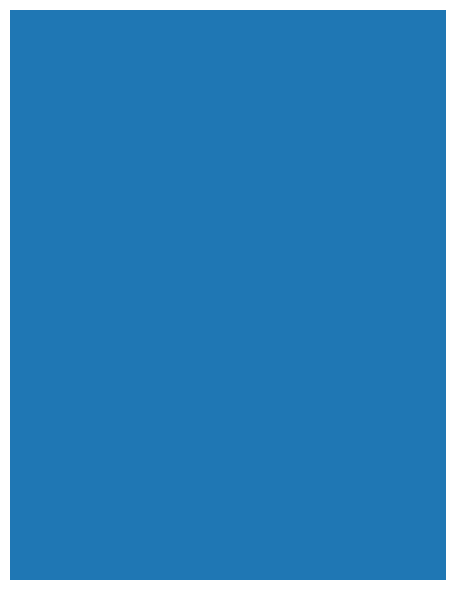

[{'id': 0, 'signed': False, 'box': [14, 14, 686, 897]}]


In [42]:
regions = []

for idx, result in results.items():
    signature = result["cropped_mask"]
    show_image(signature)
    result = judger.judge(signature)
    regions.append({"id": idx, "signed": result, "box": results[idx]["cropped_region"]})

print(regions)